# Time model
====================

The court is cut into different cell. For each cell, we would like to know the closest player taking into account inertia. Mathematical development are avalaible in the file *Closest_player_to_a_point*. Here we the results of this model, particularly, how visually we can see that it takes inertia into account

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math as m
import json
import space as sp
from data_extracter import json_extracter
import pandas as pd

data,events=json_extracter('data/game1.json')

## Function Time_to_point
----
This function returns the time required to go from point a to point b with initial speed v. F is the value of the force granted to a player (per unit of mass). A previous investigation has told that F should be closed to 10m/s [1].

In [2]:
def time_to_point(a,b,v,F=10*3.28):   
    "time to go from a to b with initial speed v, F is the force parameter in feet/s-2"
    x0,y0=a
    xf,yf=b
    X=x0-xf
    Y=y0-yf
    k4=1
    k3=0
    k2=4*(v[0]**2+v[1]**2)/F**2
    k1=8*(v[0]*X+v[1]*Y)/F**2
    k0=4*(X**2+Y**2)/F**2
    times=np.roots([k4,k3,-k2,-k1,-k0])
    for i in range(4):                      # Selection of the root real and positive
        if times[i].imag==0:
            if times[i]>0:
                return times[i].real
    print('error')
    return times[0]

## Example of trajectories with our model
-----

The black arrow represents the force and the green arrow the initial speed. 

In [3]:
def path(a,b,v,F=10*3.28,nb_points=100):
    tf=time_to_point(a,b,v,F)
    Fx=2*(b[0]-a[0]-v[0]*tf)/tf**2
    Fy=2*(b[1]-a[1]-v[1]*tf)/tf**2
    dt=tf/nb_points
    t=dt
    lx=[a[0]]
    ly=[a[1]]
    for i in range(nb_points):
        x=a[0]+v[0]*t+Fx*t**2/2
        y=a[1]+v[1]*t+Fy*t**2/2
        lx.append(x)
        ly.append(y)
        t=t+dt
    return(lx,ly,Fx,Fy,tf)

In [4]:
def print_path(a,b,v,F=10*3.28):
    lx,ly,Fx,Fy,tf=path(a,b,v,F)
    plt.plot(lx,ly)
    plt.plot(a[0],a[1], 'ro')
    plt.plot(b[0],b[1], 'bo')
    plt.arrow(a[0],a[1],Fx/10,Fy/10,shape='full',lw=1.5,head_width=0.2)
    plt.arrow(a[0],a[1],v[0],v[1],shape='full',lw=1.5,head_width=0.2, color='g')
    plt.xlim(min(v[0],Fx/10,0)-2,max(v[0],Fx/10,0)+2)
    plt.ylim(min(v[1],Fy/10,0)-2,max(v[1],Fy/10,0)+2)
    plt.show()

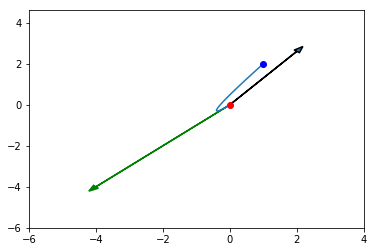

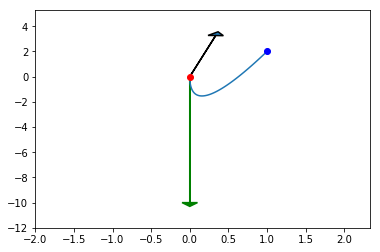

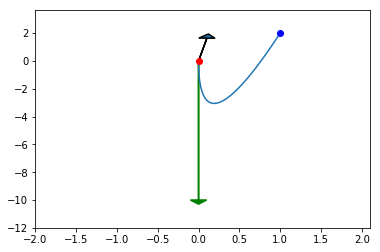

In [5]:
plt.subplots()
print_path(np.array([0,0]),np.array([1,2]),np.array([-4,-4]))
print_path(np.array([0,0]),np.array([1,2]),np.array([0,-10]))
print_path(np.array([0,0]),np.array([1,2]),np.array([0,-10]),F=5*3.28)

## Comparing our trajectories to real ones
-----

The aim is to adjust the value of F. We take the position $a$ of a player at a time t. We look where he is (point $b$) at the time t+$\Delta$t and the trajectory he made during $\Delta$t. With our model, we compute the trajectory to go from $a$ to $b$ and look at the difference between both trajectories. We iterate several time and we do this for several value of F. Then, we can adjust our F value to the one that leads to less errors.

In [6]:
def one_trajectory_error(lx,ly,lxreal,lyreal):
    MSE=0
    for x,y,xreal,yreal in zip(lx,ly,lxreal,lyreal):
        delta=(np.linalg.norm(np.array([xreal-x,yreal-y])))**2
        MSE+=delta
    return MSE
    

In [7]:
def players_ball_speed_position(moment1,moment2):
    team1,team2,ball =[],[],[]
    
    dt=0.04
    mom_infos={}
    mom_infos['ball']={}
    mom_infos['team1']={}
    mom_infos['team2']={}
    for i in range(11) :
        if i==0:
            mom_infos['ball']['xy']=np.array(moment1[i][2:4])
            mom_infos['ball']['z']=moment1[i][4]
            mom_infos['ball']['v']=np.array([(moment2[i][2]-moment1[i][2])/dt,(moment2[i][3]-moment1[i][3])/dt])
        if 6<=i<=11:
            mom_infos['team2'][str(moment1[i][1])]={'xy':np.array(moment1[i][2:4]),'v':np.array([(moment2[i][2]-moment1[i][2])/dt,(moment2[i][3]-moment1[i][3])/dt])}
        if 1<=i<=5:
            mom_infos['team1'][str(moment1[i][1])]={'xy':np.array(moment1[i][2:4]),'v':np.array([(moment2[i][2]-moment1[i][2])/dt,(moment2[i][3]-moment1[i][3])/dt])}
    return(mom_infos)

In [54]:
def event_trajectory_error(eventId,t):
    event=events[eventId]
    moments=event['moments']
    forces=[]
    errors=[]
    times=[]
    vmax=0
    for f in np.arange(3,15,0.5):
        error=[]
        TF=[]
        for mom_id in range(len(moments)-round(t/0.04)-1):
            err=0
            moment1=moments[mom_id][5]
            moment2=moments[mom_id+1][5]
            moment1f=moments[mom_id+round(t/0.04)][5]
            moment2f=moments[mom_id+round(t/0.04)+1][5]
            mom_infos=players_ball_speed_position(moment1,moment2)
            mom_infos_final=players_ball_speed_position(moment1f,moment2f)
            LX={}
            LY={}
            LXREAL={}
            LYREAL={}
            
            for player in mom_infos['team1'].keys():
                a=mom_infos['team1'][player]['xy']
                v=mom_infos['team1'][player]['v']
                normv=np.linalg.norm(v)
                if normv>vmax:
                    vmax=normv
                b=mom_infos_final['team1'][player]['xy']
                lx,ly,Fx,Fy,tf=path(a,b,v,f*3.28,round(t/0.04))
                LX[player]=lx
                LY[player]=ly
                TF.append(tf-t)
            
            for player in mom_infos['team2'].keys():
                a=mom_infos['team2'][player]['xy']
                v=mom_infos['team2'][player]['v']
                if normv>vmax:
                    vmax=normv
                b=mom_infos_final['team2'][player]['xy']
                lx,ly,Fx,Fy,tf=path(a,b,v,f*3.28,round(t/0.04))
                LX[player]=lx
                LY[player]=ly
                TF.append(tf-t)
            
            for player in mom_infos['team1'].keys():
                LXREAL[player]=[]
                LYREAL[player]=[]
            
            for player in mom_infos['team2'].keys():
                LXREAL[player]=[]
                LYREAL[player]=[]
            
            for i in range(round(t/0.04)+1):
                mom1=moments[mom_id+i][5]
                mom2=moments[mom_id+i+1][5]
                mom_infos=players_ball_speed_position(mom1,mom2)
                for player in mom_infos['team1'].keys():
                    LXREAL[player].append(mom_infos['team1'][player]['xy'][0])
                    LYREAL[player].append(mom_infos['team1'][player]['xy'][1])
                
                for player in mom_infos['team2'].keys():
                    LXREAL[player]=LXREAL[player]+[mom_infos['team2'][player]['xy'][0]]
                    LYREAL[player]=LYREAL[player]+[mom_infos['team2'][player]['xy'][1]]
            
            for player in LX.keys():
                if one_trajectory_error(LX[player],LY[player],LXREAL[player],LYREAL[player])>100 and f==10:
                    print('f:',f)
                    print(LX[player][-1],LXREAL[player][-1])
                    print(one_trajectory_error(LX[player],LY[player],LXREAL[player],LYREAL[player]))
                    plt.plot(LX[player],LY[player],'b-o')
                    plt.plot(LXREAL[player],LYREAL[player],'r-o')
                    plt.show()
                error.append(one_trajectory_error(LX[player],LY[player],LXREAL[player],LYREAL[player]))

        errors.append(error)
        forces.append(f)
        times.append(TF)
    return(errors,forces,times,vmax)
        
        

In [55]:
errors,forces,times,vmax=event_trajectory_error(0,0.4)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [10]:
vmax/3.281

3.184527600202852

In [11]:
df=pd.DataFrame(errors,index=forces)
df.T.describe()

,3.0,3.5,4.0,4.5,5.0,5.5,6.0,6.5,7.0,7.5,...,10.0,10.5,11.0,11.5,12.0,12.5,13.0,13.5,14.0,14.5
count,1390.000000,1390.000000,1390.000000,1390.000000,1390.000000,1390.000000,1390.000000,1390.000000,1390.000000,1390.000000,...,1390.000000,1390.000000,1390.000000,1390.000000,1390.000000,1390.000000,1390.000000,1390.000000,1390.000000,1390.000000
mean,6.964169,3.551456,1.720065,0.734300,0.170184,0.125682,0.134813,0.144744,0.154084,0.163314,...,0.204408,0.211970,0.219336,0.226516,0.233518,0.240350,0.247018,0.253529,0.259890,0.266107
std,25.117158,14.292526,7.863131,3.829288,0.847611,0.139406,0.148142,0.157644,0.166789,0.176196,...,0.219569,0.227936,0.236198,0.244352,0.252399,0.260339,0.268171,0.275896,0.283514,0.291027
min,0.000523,0.000553,0.000225,0.000324,0.000678,0.000732,0.000778,0.000823,0.000866,0.000908,...,0.001004,0.001016,0.001027,0.001038,0.001048,0.001057,0.001061,0.001064,0.001066,0.001069
25%,0.015157,0.018714,0.022519,0.025824,0.028563,0.031212,0.033976,0.036286,0.038058,0.040452,...,0.048957,0.050034,0.051954,0.053262,0.054228,0.055372,0.056315,0.056976,0.057804,0.058378
50%,0.038266,0.042122,0.049554,0.055561,0.062492,0.069378,0.075609,0.082722,0.088633,0.095635,...,0.122057,0.125835,0.129834,0.132787,0.139387,0.142202,0.144778,0.147667,0.151970,0.155517
75%,0.107798,0.110489,0.120346,0.134512,0.146445,0.158345,0.169694,0.184226,0.194951,0.207101,...,0.256897,0.268079,0.281212,0.292077,0.299622,0.310769,0.318061,0.324723,0.331627,0.337746
max,187.777031,112.941783,67.577695,38.338453,17.494064,0.839063,0.895568,0.954281,1.007739,1.057114,...,1.263365,1.298810,1.332794,1.365450,1.396892,1.427216,1.456507,1.484838,1.512274,1.538874


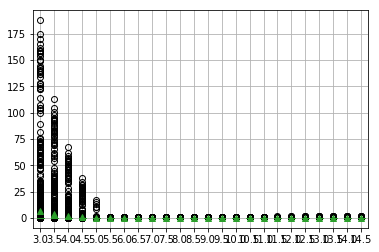

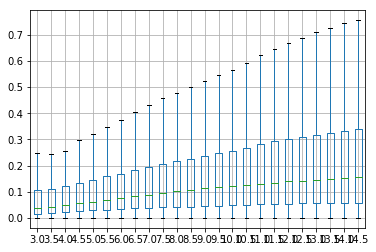

In [12]:
plt.subplots()
plt.figure(1)
df.T.boxplot(showmeans=True)
plt.figure(2)
df.T.boxplot(showfliers=False)
plt.show()

In [13]:
df2=pd.DataFrame(times,index=forces)
df2.T.describe()

,3.0,3.5,4.0,4.5,5.0,5.5,6.0,6.5,7.0,7.5,...,10.0,10.5,11.0,11.5,12.0,12.5,13.0,13.5,14.0,14.5
count,1390.000000,1390.000000,1390.000000,1390.000000,1390.000000,1390.000000,1390.000000,1390.000000,1390.000000,1390.000000,...,1390.000000,1390.000000,1390.000000,1390.000000,1390.000000,1390.000000,1390.000000,1390.000000,1390.000000,1390.000000
mean,0.055269,-0.023570,-0.080470,-0.117134,-0.146502,-0.157016,-0.164284,-0.170747,-0.176484,-0.181791,...,-0.202498,-0.205873,-0.209056,-0.212065,-0.214917,-0.217625,-0.220203,-0.222661,-0.225009,-0.227254
std,0.431591,0.316103,0.225039,0.153084,0.080251,0.066455,0.064403,0.063258,0.062331,0.061691,...,0.058278,0.057700,0.057147,0.056616,0.056104,0.055611,0.055134,0.054672,0.054225,0.053792
min,-0.339533,-0.341411,-0.343091,-0.349130,-0.352787,-0.355259,-0.357142,-0.358670,-0.359960,-0.361079,...,-0.365170,-0.365798,-0.366383,-0.366931,-0.367446,-0.367932,-0.368391,-0.368827,-0.369564,-0.370299
25%,-0.155082,-0.169813,-0.181477,-0.190341,-0.198190,-0.205497,-0.211856,-0.217714,-0.222730,-0.227430,...,-0.245283,-0.247969,-0.250599,-0.253435,-0.255942,-0.258461,-0.260604,-0.262811,-0.264929,-0.266684
50%,-0.093348,-0.111062,-0.124841,-0.136507,-0.146079,-0.154649,-0.163325,-0.170598,-0.177134,-0.182000,...,-0.204708,-0.207980,-0.211202,-0.214094,-0.217102,-0.220130,-0.222837,-0.225303,-0.227576,-0.230030
75%,-0.015947,-0.045457,-0.070056,-0.085613,-0.099016,-0.109107,-0.116584,-0.123832,-0.129362,-0.135091,...,-0.157535,-0.161174,-0.164528,-0.168250,-0.171695,-0.174631,-0.177775,-0.180629,-0.183281,-0.186268
max,1.799531,1.394079,1.076804,0.809368,0.544507,0.159757,0.040541,-0.004616,-0.029421,-0.042282,...,-0.077364,-0.083119,-0.088551,-0.093690,-0.098562,-0.103190,-0.107594,-0.111793,-0.115803,-0.119637


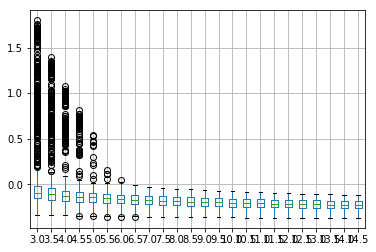

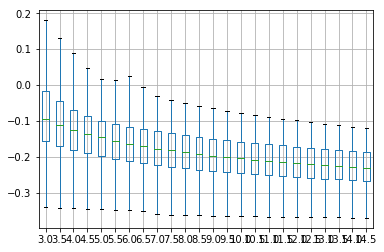

In [14]:
plt.subplots()
plt.figure(1)
df2.T.boxplot()
plt.figure(2)
df2.T.boxplot(showfliers=False)
plt.show()

In [15]:
def path_bis(a,b,v,tf,nb_points=100):
    Fx=2*(b[0]-a[0]-v[0]*tf)/tf**2
    Fy=2*(b[1]-a[1]-v[1]*tf)/tf**2
    dt=tf/nb_points
    t=dt
    lx=[a[0]]
    ly=[a[1]]
    for i in range(nb_points):
        x=a[0]+v[0]*t+Fx*t**2/2
        y=a[1]+v[1]*t+Fy*t**2/2
        lx.append(x)
        ly.append(y)
        t=t+dt
    return [lx,ly,Fx,Fy]

In [42]:
def event_trajectory_error_bis(eventId,t):
    event=events[eventId]
    moments=event['moments']
    forces=[]
    error=[]
        
    for mom_id in range(len(moments)-round(t/0.04)-1):
        moment1=moments[mom_id][5]
        moment2=moments[mom_id+1][5]
        moment1f=moments[mom_id+round(t/0.04)][5]
        moment2f=moments[mom_id+round(t/0.04)+1][5]
        mom_infos=players_ball_speed_position(moment1,moment2)
        mom_infos_final=players_ball_speed_position(moment1f,moment2f)
        LX={}
        LY={}
        LXREAL={}
        LYREAL={}
        acc={}
        
        for player in mom_infos['team1'].keys():
            a=mom_infos['team1'][player]['xy']
            v=mom_infos['team1'][player]['v']
            b=mom_infos_final['team1'][player]['xy']
            lx,ly,Fx,Fy=path_bis(a,b,v,t,round(t/0.04))
            f=np.linalg.norm(np.array([Fx,Fy]))/3.281
            forces.append(f)
            acc[player]=f
            LX[player]=lx
            LY[player]=ly
            
        for player in mom_infos['team2'].keys():
            a=mom_infos['team2'][player]['xy']
            v=mom_infos['team2'][player]['v']
            b=mom_infos_final['team2'][player]['xy']
            lx,ly,Fx,Fy=path_bis(a,b,v,t,round(t/0.04))
            f=np.linalg.norm(np.array([Fx,Fy]))/3.281
            forces.append(f)
            acc[player]=f
            LX[player]=lx
            LY[player]=ly
            
        for player in mom_infos['team1'].keys():
            LXREAL[player]=[]
            LYREAL[player]=[]
            
        for player in mom_infos['team2'].keys():
            LXREAL[player]=[]
            LYREAL[player]=[]
            
        for i in range(round(t/0.04)+1):
            mom1=moments[mom_id+i][5]
            mom2=moments[mom_id+i+1][5]
            mom_infos=players_ball_speed_position(mom1,mom2)
            for player in mom_infos['team1'].keys():
                LXREAL[player].append(mom_infos['team1'][player]['xy'][0])
                LYREAL[player].append(mom_infos['team1'][player]['xy'][1])
                
            for player in mom_infos['team2'].keys():
                LXREAL[player]=LXREAL[player]+[mom_infos['team2'][player]['xy'][0]]
                LYREAL[player]=LYREAL[player]+[mom_infos['team2'][player]['xy'][1]]
        
        for player in LX.keys():
            if acc[player]>6:
                print(LX[player][-1],LXREAL[player][-1])
                print(one_trajectory_error(LX[player],LY[player],LXREAL[player],LYREAL[player]))
                plt.plot(LX[player],LY[player],'b-o')
                plt.plot(LXREAL[player],LYREAL[player],'r-o')
                plt.show()
            error.append(one_trajectory_error(LX[player],LY[player],LXREAL[player],LYREAL[player]))
            
    error=pd.DataFrame(error)
    forces=pd.DataFrame(forces)
    return(error,forces)

27.05314 27.05314
0.011506105402


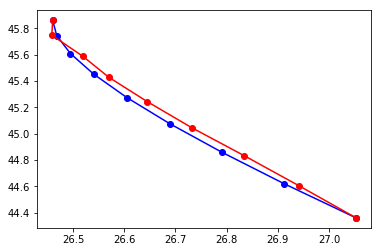

15.33594 15.33594
0.0335496682484


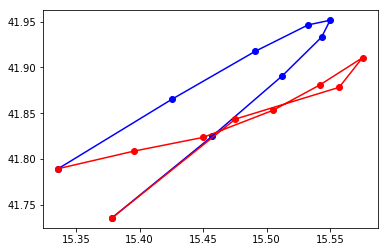

15.25071 15.25071
0.0221019989388


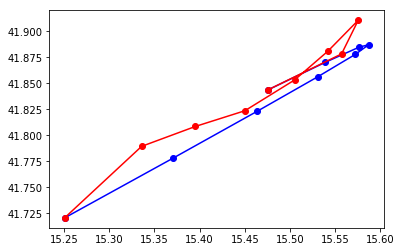

14.5595 14.5595
0.0484615799985


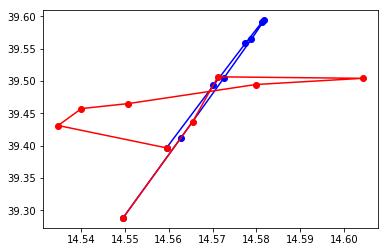

16.16622 16.16622
0.0145018979485


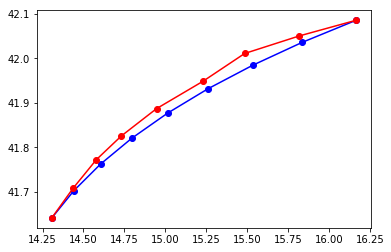

16.51366 16.51366
0.00489440010239


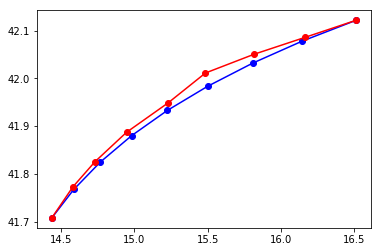

16.84849 16.84849
0.0335604252954


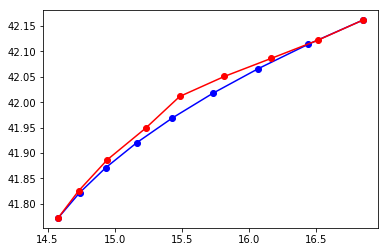

11.75933 11.75933
0.0140375360614


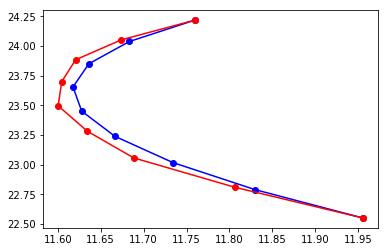

11.87537 11.87537
0.00448799994915


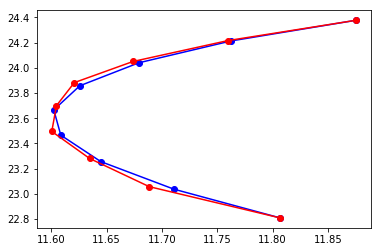

In [52]:
error,forces=event_trajectory_error_bis(0,0.3)

In [53]:
forces.describe()

,0
count,1410.000000
mean,1.871217
std,1.224446
min,0.044105
25%,0.924381
50%,1.582479
75%,2.587033
max,7.653751


In [33]:
error.describe()

,0
count,1390.000000
mean,0.014380
std,0.026299
min,0.000037
25%,0.002259
50%,0.006018
75%,0.013788
max,0.316483


## Looking at acceleration value
-----

In [20]:
event=events[0]
moments=event['moments']
def acceleration():
    global event
    global moments
    a=[]
    for mom_id in range(len(moments)-2):
        mom1=moments[mom_id][5]
        mom2=moments[mom_id+1][5]
        mom3=moments[mom_id+2][5]
        mom_infos1=players_ball_speed_position(mom1,mom2)
        mom_infos2=players_ball_speed_position(mom2,mom3)
        for player in mom_infos1['team1'].keys():
            v1=mom_infos1['team1'][player]['v']
            v2=mom_infos2['team1'][player]['v']
            a.append(np.linalg.norm(v2-v1)/(3.281*0.04))
        for player in mom_infos1['team2'].keys():
            v1=mom_infos1['team2'][player]['v']
            v2=mom_infos2['team2'][player]['v']
            a.append(np.linalg.norm(v2-v1)/(3.281*0.04))
    
    return(pd.DataFrame(a))
        
    

In [21]:
acc=acceleration()
acc.describe()

,0
count,1480.000000
mean,3.004365
std,2.673598
min,0.074194
25%,1.301119
50%,2.290348
75%,3.672248
max,19.239710


In [62]:
def event_trajectory_error_high_acc(eventId,t):
    event=events[eventId]
    moments=event['moments']
    forces=[]
    errors=[]
    times=[]
    vmax=0
    for f in np.arange(3,15,0.5):
        error=[]
        TF=[]
        for mom_id in range(len(moments)-round(t/0.04)-1):
            err=0
            moment1=moments[mom_id][5]
            moment2=moments[mom_id+1][5]
            moment3=moments[mom_id+2][5]
            moment1f=moments[mom_id+round(t/0.04)][5]
            moment2f=moments[mom_id+round(t/0.04)+1][5]
            mom_infos=players_ball_speed_position(moment1,moment2)
            mom_infos_2=players_ball_speed_position(moment2,moment3)
            mom_infos_final=players_ball_speed_position(moment1f,moment2f)
            LX={}
            LY={}
            LXREAL={}
            LYREAL={}
            
            for player in mom_infos['team1'].keys():
                a=mom_infos['team1'][player]['xy']
                v=mom_infos['team1'][player]['v']
                v2=mom_infos_2['team1'][player]['v']
                acc=(np.linalg.norm(v2-v))/0.04
                b=mom_infos_final['team1'][player]['xy']
                if acc>10*3.28:
                    lx,ly,Fx,Fy,tf=path(a,b,v,f*3.28,round(t/0.04))
                    LX[player]=lx
                    LY[player]=ly
                    TF.append(tf-t)
            
            for player in mom_infos['team2'].keys():
                a=mom_infos['team2'][player]['xy']
                v=mom_infos['team2'][player]['v']
                b=mom_infos_final['team2'][player]['xy']
                acc=(np.linalg.norm(v2-v))/0.04
                if acc>10*3.28:
                    lx,ly,Fx,Fy,tf=path(a,b,v,f*3.28,round(t/0.04))
                    LX[player]=lx
                    LY[player]=ly
                    TF.append(tf-t)
            
            for player in mom_infos['team1'].keys():
                LXREAL[player]=[]
                LYREAL[player]=[]
            
            for player in mom_infos['team2'].keys():
                LXREAL[player]=[]
                LYREAL[player]=[]
            
            for i in range(round(t/0.04)+1):
                mom1=moments[mom_id+i][5]
                mom2=moments[mom_id+i+1][5]
                mom_infos=players_ball_speed_position(mom1,mom2)
                for player in mom_infos['team1'].keys():
                    LXREAL[player].append(mom_infos['team1'][player]['xy'][0])
                    LYREAL[player].append(mom_infos['team1'][player]['xy'][1])
                
                for player in mom_infos['team2'].keys():
                    LXREAL[player]=LXREAL[player]+[mom_infos['team2'][player]['xy'][0]]
                    LYREAL[player]=LYREAL[player]+[mom_infos['team2'][player]['xy'][1]]
            
            for player in LX.keys():
                if one_trajectory_error(LX[player],LY[player],LXREAL[player],LYREAL[player])>100 and f==10:
                    print('f:',f)
                    print(LX[player][-1],LXREAL[player][-1])
                    print(one_trajectory_error(LX[player],LY[player],LXREAL[player],LYREAL[player]))
                    plt.plot(LX[player],LY[player],'b-o')
                    plt.plot(LXREAL[player],LYREAL[player],'r-o')
                    plt.show()
                error.append(one_trajectory_error(LX[player],LY[player],LXREAL[player],LYREAL[player]))

        errors.append(error)
        forces.append(f)
        times.append(TF)
    return(errors,forces,times,vmax) 

In [63]:
errors,forces,times,vmax=event_trajectory_error_high_acc(0,0.4)

In [64]:
df=pd.DataFrame(errors,index=forces)
df.T.describe()

,3.0,3.5,4.0,4.5,5.0,5.5,6.0,6.5,7.0,7.5,...,10.0,10.5,11.0,11.5,12.0,12.5,13.0,13.5,14.0,14.5
count,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,...,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000
mean,13.226693,7.063306,3.619115,1.530940,0.262795,0.156897,0.169160,0.181710,0.193447,0.205344,...,0.258194,0.268056,0.277696,0.287121,0.296338,0.305354,0.314175,0.322807,0.331258,0.339533
std,35.898701,20.634966,11.461016,5.643697,1.257361,0.150087,0.158880,0.168488,0.177704,0.187626,...,0.233537,0.242684,0.251790,0.260846,0.269842,0.278773,0.287632,0.296414,0.305115,0.313732
min,0.000697,0.000831,0.001101,0.001241,0.002109,0.002710,0.003087,0.003176,0.003258,0.003334,...,0.003642,0.003693,0.003741,0.003786,0.003829,0.003871,0.003910,0.003947,0.003983,0.004017
25%,0.024954,0.027592,0.032410,0.038956,0.043522,0.047799,0.052384,0.057061,0.058540,0.062842,...,0.080515,0.082964,0.085800,0.087336,0.088759,0.090984,0.093513,0.096259,0.097998,0.100372
50%,0.054925,0.062266,0.070490,0.079482,0.090464,0.100124,0.111270,0.122197,0.134614,0.144822,...,0.179748,0.186165,0.194454,0.200392,0.206887,0.213681,0.219781,0.226375,0.231588,0.237243
75%,0.232674,0.199129,0.198723,0.205332,0.207376,0.221672,0.244096,0.273280,0.291200,0.298736,...,0.355429,0.366821,0.386121,0.405097,0.419696,0.432432,0.439865,0.450557,0.464533,0.472798
max,187.777031,112.941783,67.577695,38.338453,17.494064,0.746235,0.751839,0.757136,0.762157,0.766928,...,0.912613,0.947885,0.985232,1.021943,1.058030,1.093504,1.129194,1.165293,1.200824,1.235798


# Lag study
==================

At this point we don't know how to determine the force F given to a player. We tried to do that by comparing real trajectory to the one our model give to go from point a to point b. But the results were not satistying as long as most precised trajectories considering the median were those with weak strength but they were also those with the largest differences for some trajectories. However, our will is not to have the same trajectory as real one : we want to have the trajectory a player would have if he wanted to go from a to b giving all the strength he has. 

One thing we have observed is that time model seems to lag distance model. This, is a very interesting thing. We are going to study this lag with different values for the strength. To do so, we calculated the correlation between space occupation with time and distance model and it gave us the lag. Here are the results.

In [11]:
import pandas as pd
lags=pd.read_csv('data/total_df.csv',sep = ',',index_col=[1,0,2])
lags.fillna(0,inplace=True)

In [12]:
lags

R  tau       rho   time
     Unnamed: 0 Unnamed: 2                                
1    5          0           0.000000    0  0.000000  19.72
                1           0.000000    0  0.000000  19.72
                2           0.000000    0  0.000000  19.72
                3           0.000000    0  0.000000  19.72
                4           0.000000    0  0.000000  19.72
                5           0.000000    0  0.000000  19.72
                6           0.000000    0  0.000000  19.72
                7           0.000000    0  0.000000  19.72
                8           0.000000    0  0.000000  19.72
                9           0.000000    0  0.000000  19.72
                10          0.000000    0  0.000000  19.72
                11          0.000000    0  0.000000  19.72
                12          0.000000    0  0.000000  19.72
                13          0.000000    0  0.000000  19.72
                14          0.000000    0  0.000000  19.72
                15          0.000000    0  0.000000  19.72
                16          0.000000    0  0.000000  19.72
                17          0.000000    0  0.000000  19.72
                18          0.000000    0  0.000000  19.72
                19          0.000000    0  0.000000  19.72
                20          0.000000    0  0.000000  19.72
                21          0.000000    0  0.000000  19.72
                22          0.000000    0  0.000000  19.72
                23          0.000000    0  0.000000  19.72
                24          0.000000    0  0.000000  19.72
                25          0.000000    0  0.000000  19.72
                26          0.000000    0  0.000000  19.72
                27          0.000000    0  0.000000  19.72
                28          0.000000    0  0.000000  19.72
                29          0.000000    0  0.000000  19.72
...                              ...  ...       ...    ...
1000 58         95         -0.045490   18  0.775344  13.05
                96         -0.051158   18  0.775344  13.05
                97         -0.056418   18  0.775344  13.05
                98         -0.062030   18  0.775344  13.05
                99         -0.067561   18  0.775344  13.05
                100        -0.072922   18  0.775344  13.05
                101        -0.078193   18  0.775344  13.05
                102        -0.083476   18  0.775344  13.05
                103        -0.088715   18  0.775344  13.05
                104        -0.093909   18  0.775344  13.05
                105        -0.099097   18  0.775344  13.05
                106        -0.104177   18  0.775344  13.05
                107        -0.109201   18  0.775344  13.05
                108        -0.114085   18  0.775344  13.05
                109        -0.118850   18  0.775344  13.05
                110        -0.123445   18  0.775344  13.05
                111        -0.127929   18  0.775344  13.05
                112        -0.132207   18  0.775344  13.05
                113        -0.136420   18  0.775344  13.05
                114        -0.140495   18  0.775344  13.05
                115        -0.144659   18  0.775344  13.05
                116        -0.148631   18  0.775344  13.05
                117        -0.152432   18  0.775344  13.05
                118        -0.156037   18  0.775344  13.05
                119        -0.159296   18  0.775344  13.05
                120        -0.162369   18  0.775344  13.05
                121        -0.165551   18  0.775344  13.05
                122        -0.168659   18  0.775344  13.05
                123        -0.171684   18  0.775344  13.05
                124        -0.174657   18  0.775344  13.05

[71875 rows x 4 columns]

## Correlation max function of force

In [2]:
lags[['rho']].max(level=(0,1))

NameError: name 'lags' is not defined

## Sources 
[1] Akira Fujimura and Kokichi Sugihara. Geo- metric analysis and quantitative evaluation of sport teamwork. *Systems and Computers in Japan*, 36(6):49–58, 2005.